## Data Exploration - Aerial Historical Images

In [31]:
%%capture
import re
import glob
from os import path
import numpy as np
import pandas as pd

import geopandas as gpd
import fiona
import rioxarray as rxr
import xarray as xr
import cv2
from skimage.io import imread

import matplotlib.pyplot as plt
import plotly.express as px

#### Reading the data

In [32]:
# data paths
MASKS_PATH = '..\data\mask'
IMAGES_PATH = '..\data\clipped_images'

img_paths = glob.glob(IMAGES_PATH +'\*')
mask_paths = glob.glob(MASKS_PATH +'\*')

In [51]:
# getting file names
def get_file_name(paths):
    ''' Returns file_name.tif'''
    return [img.split('\\')[-1].split('.')[0] for img in paths]

mask_name = get_file_name(mask_paths)
img_name = get_file_name(img_paths)

In [35]:
# XARRAY TRAINING 

# def read_files(paths, file_name):
#     xr_imgs = rxr.open_rasterio(f'{paths}\{file_name}').squeeze().astype(np.uint8)
#     xr_imgs.name = i.split('.')[0]
#     return xr_imgs

# xarrays_masks = []
# xarrays_imgs = []

# for i in mask_name:
#     # check if mask has a corresponding image
#     if np.isin(i, img_name):
#         # read masks
#         xarrays_masks.append(read_files(MASKS_PATH, i))
#         # read images 
#         xarrays_imgs.append(read_files(IMAGES_PATH, i))
# masks = xr.merge(xarrays_masks)
# images = xr.merge(xarrays_imgs)

In [50]:
def read_files(paths, file_name):
    ''' Returns images and corresponding year '''
    imgs = imread(f'{paths}\{file_name}.tif')
    # year = file_name.split('.')[0]
    return imgs

masks_dic = {}
imgs_dict = {}

for year in mask_name:
    if np.isin(year, img_name): # check if mask has a corresponding image
        # read image and mask
        imgs = read_files(IMAGES_PATH, year)
        masks = read_files(MASKS_PATH, year)

        # update dictionaries
        imgs_dict.update({year:imgs})
        masks_dic.update({year:np.flip(masks)})

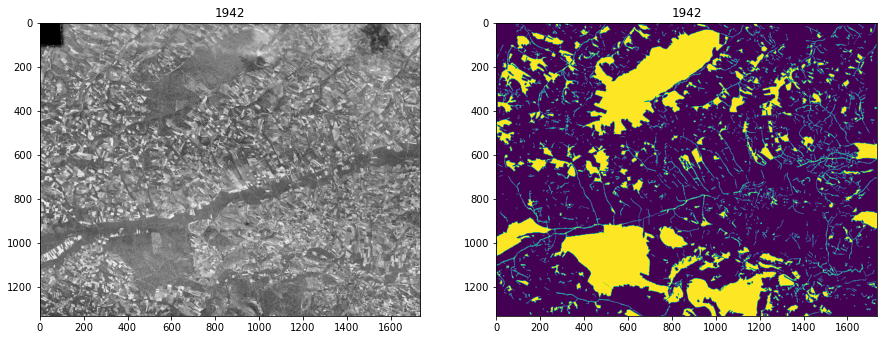

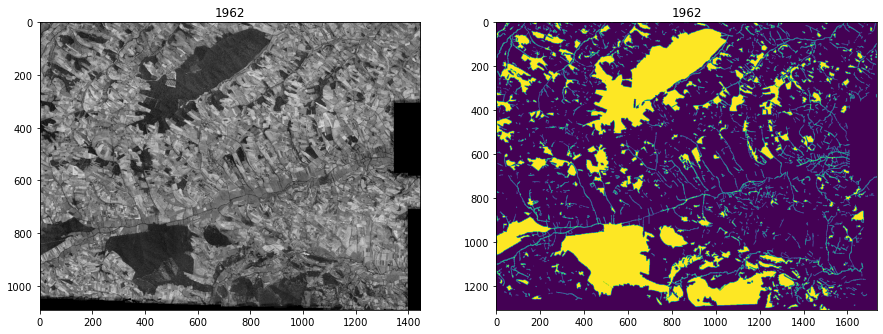

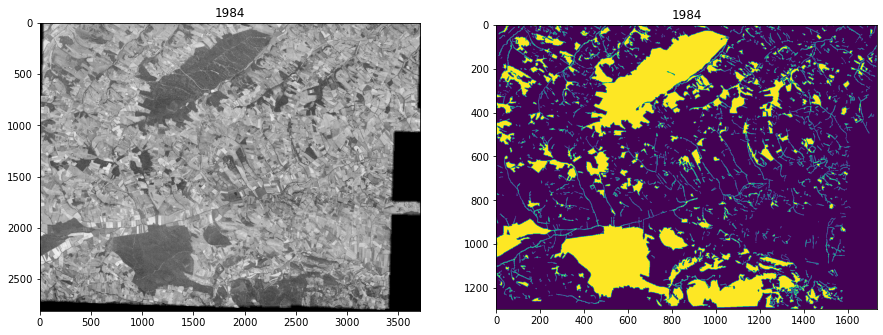

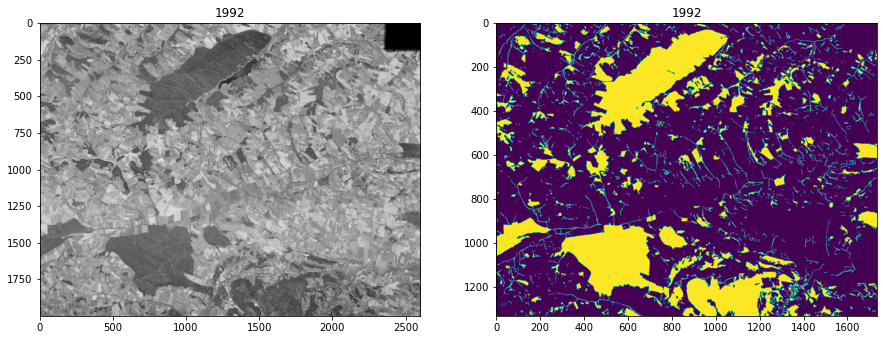

In [ ]:
# Plot
def plot_comparison(img1, img2, title):
    ''' Plot comparison between two plots'''
    n_col = 2
    _, axs = plt.subplots(1, n_col, figsize=(15, 20))
    
    axs[0].imshow(img1[::10,::10], cmap='gray')
    axs[0].set_title(title)
    axs[1].imshow(img2[::10,::10])
    axs[1].set_title(title)
    
    plt.show()

for year in imgs_dict.keys():
    plot_comparison(imgs_dict[year], masks_dic[year], year)


**Data Distribution**

In [ ]:
# Calculates the average count of vegetation and non-vegetation layers 
counts = np.zeros((len(masks_dic), 2))

for i, year in enumerate(masks_dic.keys()):
    counts[i] = np.unique(masks_dic[year], return_counts=True)[1]

avg_counts = counts.mean(axis=0)
avg_counts

array([1.76654936e+08, 5.17922650e+07])

In [ ]:
# Plotting data distribution
df_avg_veg = {'average vegetation count': avg_counts, 'label': ['non-vegetation','vegetation']}
fig = px.pie(df_avg_veg, names='label', values='average vegetation count', color_discrete_sequence=px.colors.diverging.RdYlGn_r, 
title='Average percentage of vegetation and non-vegetation classes')

fig.update_layout(legend=dict(
    yanchor="top",
    y= 0.8,
    xanchor="right",
    x = 0.75))

# ['#CEAF81', '#6BA174'] # alternative colors

In [ ]:
# plt.figure(figsize=(10,20))
# plt.pie(avg_counts, autopct='%1.1f%%',
#         shadow=True, startangle=90)
# plt.show()

**Area by year**

In [ ]:
GPKG_PATH = '..\data\mask_per_year.gpkg'
years = fiona.listlayers(GPKG_PATH)[1:] # list layers/years
years.sort()
# read the masks 
mask_per_year = {}
u_year = list(masks_dic.keys()) # in case of using only the years on the ground truth 

# for year in years:
#     if np.isin(year, u_year):

mask_per_year = {key: gpd.read_file(GPKG_PATH, layer=key) for key in years}

mask_per_year['1942'].head()

,ID,PREC_PLANI,NATURE,geometry
0,ZONEARBO0000000036808850,5.0,Zone arborÃ©e,"MULTIPOLYGON (((520864.372 6248151.085, 520866..."
1,ZONEARBO0000000036808850,5.0,Zone arborÃ©e,"MULTIPOLYGON (((519843.100 6246716.100, 519841..."
2,ZONEARBO0000000036808850,5.0,Zone arborÃ©e,"MULTIPOLYGON (((525365.487 6246165.322, 525403..."
3,ZONEARBO0000000036808850,5.0,Zone arborÃ©e,"MULTIPOLYGON (((529215.800 6239090.300, 529216..."
4,ZONEARBO0000000036808850,5.0,Zone arborÃ©e,"MULTIPOLYGON (((530338.900 6239116.900, 530343..."


In [ ]:
# create a df with veg area by year
area_by_year = {year:np.sum(mask_per_year[year].area) for year in years}
df_area = pd.DataFrame.from_dict(area_by_year, orient='index', columns=['area']).reset_index()
df_area.rename(columns={'index': 'year'}, inplace=True)

In [ ]:
px.line(df_area, x='year', y='area', 
color_discrete_sequence=px.colors.diverging.RdYlGn_r, title= 'Total area (m²) of the ground truth layers over the years')

**Image Histograms**

In [95]:
# read the all images, this time without the limitation of having a mask ready or not
all_imgs = {year: read_files(IMAGES_PATH, year) for year in img_name}

# store and sort the shape of the images
shapes = [img.shape for img in all_imgs.values()]
shapes.sort()
print(shapes)

# Resize the images 
for year in img_name:
    all_imgs.update({year:cv2.resize(all_imgs[year], dsize= np.flip(shapes[0]), interpolation=cv2.INTER_CUBIC)})

[(10917, 14445), (13333, 17334), (16666, 21667), (16666, 21667), (16666, 21667), (16666, 21667), (18181, 23636), (20000, 26000), (28091, 37143)]


In [60]:
# resize the images (due to various resolutions)

all_imgs['1942']


array([[  0,   0,   0, ..., 169, 171, 172],
       [  0,   0,   0, ..., 192, 190, 189],
       [  0,   0,   0, ..., 199, 199, 200],
       ...,
       [165, 172, 176, ..., 165, 156, 140],
       [172, 173, 173, ..., 184, 183, 195],
       [193, 185, 184, ..., 196, 203, 218]], dtype=uint8)

In [ ]:

# resize the images (due to various resolutions)

# plot a histogram per image

In [ ]:
# plot_comparison(img1, img2, title)

In [ ]:
imgs_dict['1942']

array([[  0,   0,   0, ..., 169, 171, 172],
       [  0,   0,   0, ..., 192, 190, 189],
       [  0,   0,   0, ..., 199, 199, 200],
       ...,
       [165, 172, 176, ..., 165, 156, 140],
       [172, 173, 173, ..., 184, 183, 195],
       [193, 185, 184, ..., 196, 203, 218]], dtype=uint8)